In [1]:
import os
import json
import csv
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Essential Dictionaries / lists

In [2]:
directory = 'densepose/txt'

#get directories without hidden files
directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
directories.sort()

#Setup dictionary to collect file names
all_file_names = {}

#Identify all file names
for d in directories:
    #get file names without hidden files
    files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
    files.sort()
    all_file_names[d] = files

In [3]:
#Count the number of videos in each video type
#Determined by checking last number string on each image and
#checking if it matches '0001'
num_videos = {}
first_img_indexes = {}

for d in directories:
    video_count = 0
    num_images = len(all_file_names[d])
    for i in range(num_images):
        if all_file_names[d][i].split('.')[0].split('_')[-1] == '0001':
            video_count += 1
    num_videos[d] = video_count

In [4]:
#Print out summary results
print(f"{'dance':<9} | {'Num Images':<10} | {'Num Videos':<9}")
print("-"*35)
for k,v in all_file_names.items():
    print(f'{k:<9} | {len(v):<10} | {num_videos[k]}')

dance     | Num Images | Num Videos
-----------------------------------
ballet    | 22410      | 89
break     | 25622      | 95
cha       | 28098      | 98
flamenco  | 24755      | 88
foxtrot   | 23738      | 79
jive      | 29100      | 106
latin     | 24460      | 90
pasodoble | 26607      | 98
quickstep | 24036      | 82
rumba     | 27262      | 94
samba     | 25807      | 96
square    | 27453      | 97
swing     | 26337      | 95
tango     | 24020      | 80
tap       | 28541      | 95
waltz     | 24380      | 80


In [5]:
# getting the names of videos and adding them to a dictionary under the dance style they belong to
# video_names = {key=DanceStyle : value=[VideoName0, VideoName1, etc.]}
video_names = {}
for d in directories:
    dance_names = []
    for x in all_file_names[d]:
        sliced_name = x[0:-9]
        if sliced_name not in dance_names:
            dance_names.append(sliced_name)
    video_names[d] = dance_names

In [6]:
# Validation: should return 89
print(len(video_names['ballet']))

89


In [7]:
#video_names

## Function: Number of people in a frame

In [9]:
def person_count(file_name):
    '''Input a JSON file and get the number of people in each frame. '''
    f = open(file_name, "r")
    j = json.load(f)
    f.close

    people_count = len(j)

    return people_count

In [10]:
# Testing results, should return 5
peeps = person_count('densepose/txt/ballet/-5Yp-vToI2E_016_0001.json')
peeps

5

## Functions: Get body position & Body parts

In [11]:
def get_body_position_info(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close
    people= []

    for i,person in enumerate(j):
        #Set up list to collect person's body location
        person_i = []
        count = 0

        #add each body part position to the list
        for body_part in person:
            count+=1
            if count == 1: continue
            else: person_i.append(body_part[1])

        #Append entire list to list of people
        people.append(person_i)

    return people

In [13]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(predictions, test_labels)
    print('Model Performance')
    print('Test Set Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Swing and Latin Model with 2 people (only)

From our graphs in notebook Project_EDA, we can see that Swing and Latin have the highest number of frames with 2 people (~5,000). Because both of these classes have similar number of examples and have the highest number of examples, we will use these dance coordinates for a model with 2 people.

In [14]:
# creating a dictionary to hold each video and all of its frames {video_name: [frame1, frame2, etc.]}
videos_swing = {}
videos_latin = {}

# looping through all dance styles
for d in directories:
    # dict to store avg number of people per video for 1 dance style
    vid_dict = {}
    
    if d == 'swing':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct == 2:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_swing = vid_dict

    if d == 'latin':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct == 2:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_latin = vid_dict


print("Number of selected files for swing:", len(videos_swing))
print("Number of selected files for latin:", len(videos_latin))

Number of selected files for swing: 95
Number of selected files for latin: 90


In [15]:
# making sure no null frames are present
videos_swing = {k: v for k, v in videos_swing.items() if len(v) != 0}
videos_latin = {k: v for k, v in videos_latin.items() if len(v) != 0}

print("New Number of selected files for swing:", len(videos_swing))
print("New Number of selected files for tap:", len(videos_latin))

New Number of selected files for swing: 39
New Number of selected files for tap: 61


In [16]:
# SPLIT

X_train_swing = []
X_val_swing = []
X_test_swing = []
X_train_latin = []
X_val_latin = []
X_test_latin = []

# append 80% of keys (80% of the key count, but append the contents) to a list of X_train_swing
split_swing = int((len(videos_swing)*80)/100)
split_val = int(split_swing * .10)
split_train = split_swing - split_val
split_val_length = split_val + split_train
s = 0
print('Train split for swing should have :', split_train, 'videos. \nValidation set should have: ', 
      split_val, 'videos. \nTest set should have ', len(videos_swing) - split_swing, 'videos.')
print('-'*50)

# v is the name of the video
# f is the files (with paths) in the video
for v, f in videos_swing.items():
    #print('s is: ', s)
    if s < split_train:
        s += 1
        X_train_swing.append(f)
    elif s >= split_train and s < split_val_length:
        s += 1
        X_val_swing.append(f)
    else:
        X_test_swing.append(f)

split_latin= int((len(videos_latin)*80)/100)
split_val2 = int(split_latin* .10)
split_train2 = split_latin- split_val2
split_val_length2 = split_val2 + split_train2
l = 0

print('Train split for latin should have :', split_train2, 'videos. \nValidation set should have: ', 
      split_val2, 'videos.\nTest set should have ', len(videos_latin) - split_latin, 'videos.')
print('-'*50)

for v, f in videos_latin.items():
    #print('l is', l)
    if l < split_train2:
        l += 1
        X_train_latin.append(f)
    elif l >= split_train2 and l < split_val_length2:
        l += 1
        X_val_latin.append(f)
    else:
        X_test_latin.append(f)


print('swing train set length:',len(X_train_swing))
print('swing validation set length:',len(X_val_swing))
print('swing test set length:',len(X_test_swing))
print('latin train set length:',len(X_train_latin))
print('latin validation set length:',len(X_val_latin))
print('latin test set length:',len(X_test_latin))

Train split for swing should have : 28 videos. 
Validation set should have:  3 videos. 
Test set should have  8 videos.
--------------------------------------------------
Train split for latin should have : 44 videos. 
Validation set should have:  4 videos.
Test set should have  13 videos.
--------------------------------------------------
swing train set length: 28
swing validation set length: 3
swing test set length: 8
latin train set length: 44
latin validation set length: 4
latin test set length: 13


In [17]:
# combine arrays
X_train_files = X_train_swing + X_train_latin
X_val_files = X_val_swing + X_val_latin
X_test_files = X_test_swing + X_test_latin

In [18]:
# Initialize lists to store feature data and corresponding labels
train_feature_data = []
train_feature_data_flattened = []

train_labels = []

# Iterate through each json file representing a frame in the training set
for file in X_train_files: 
    for f in file:
        #print('file is: ', file)
        
        #getting body positions for people in frame
        body_positions = get_body_position_info(f)#[0]
        #print(body_positions)
        train_feature_data.append(body_positions)
    
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
    
        # Append the flattened positions to the feature data list
        train_feature_data_flattened.append(flattened_positions)
        
        # Determine the label based on the file path (e.g., swing or latin)
        if 'swing' in f:
            label = 'swing'
        elif 'latin' in f:
            label = 'latin'
        #elif 'latin' in f:
        #    label = 'latin'
        else:
            label = 'unknown'
        train_labels.append(label)

In [19]:
# Convert the training feature data and labels into numpy arrays
X_train = np.array(train_feature_data)
X_train_flattened = np.array(train_feature_data_flattened)
y_train = np.array(train_labels)

print("Number of frames (rows) in X_train:", len(X_train_flattened))
print("Number of features (columns) in X_train:", len(X_train_flattened[0]))
print("Number of labels in y_train:", len(y_train))

Number of frames (rows) in X_train: 7337
Number of features (columns) in X_train: 34
Number of labels in y_train: 7337


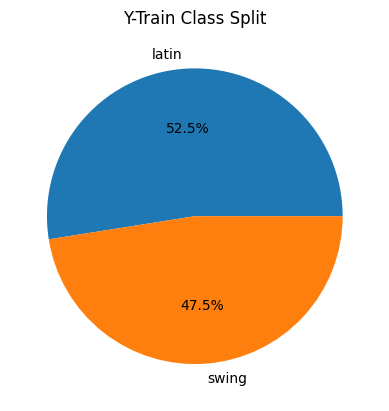

In [20]:
y_train_split = np.unique(y_train, return_counts=True)

plt.pie(y_train_split[1], labels = y_train_split[0], autopct='%1.1f%%')
plt.title('Y-Train Class Split')
plt.show()

In [21]:
# repeating for validation set

# Initialize lists to store feature data and corresponding labels
val_feature_data = []
val_feature_data_flattened = []

val_labels = []

# Iterate through each json file representing a frame in the training set
for file in X_val_files: 
    for f in file:
        #print('file is: ', file)
        
        #getting body positions for people in frame
        body_positions = get_body_position_info(f)#[0]
        #print(body_positions)
        val_feature_data.append(body_positions)
    
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
    
        # Append the flattened positions to the feature data list
        val_feature_data_flattened.append(flattened_positions)
        
        # Determine the label based on the file path (e.g., swing or latin)
        if 'swing' in f:
            label = 'swing'
        elif 'latin' in f:
            label = 'latin'
        else:
            label = 'unknown'
        val_labels.append(label)

In [22]:
# Convert the training feature data and labels into numpy arrays
X_val = np.array(val_feature_data)
X_val_flattened = np.array(val_feature_data_flattened)
y_val = np.array(val_labels)

print("Number of frames (rows) in X_val:", len(X_val_flattened))
print("Number of features (columns) in X_val:", len(X_val_flattened[0]))
print("Number of labels in y_val:", len(y_val))

Number of frames (rows) in X_val: 700
Number of features (columns) in X_val: 34
Number of labels in y_val: 700


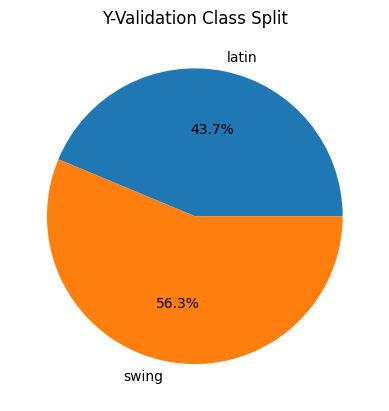

In [23]:
y_val_split = np.unique(y_val, return_counts=True)

plt.pie(y_val_split[1], labels = y_val_split[0], autopct='%1.1f%%')
plt.title('Y-Validation Class Split')
plt.show()

In [24]:
# repeating above steps for test data

# Initialize lists to store feature data and corresponding labels for the testing set
test_feature_data = []
test_labels = []

# Iterate through each JSON file representing a frame in the testing set
for file in X_test_files:
    for f in file:
        # Get body position info for the single person in the frame
        body_positions = get_body_position_info(f)
        
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
        
        # Append the flattened positions to the feature data list for the testing set
        test_feature_data.append(flattened_positions)
    
         # Determine the label based on the file path (e.g., swing or latin)
        if 'swing' in f:
            label = 'swing'
        elif 'latin' in f:
            label = 'latin'
        else:
            label = 'unknown'
        test_labels.append(label)

# Convert the testing feature data and labels into numpy arrays
X_test_flattened = np.array(test_feature_data)
y_test = np.array(test_labels)

print("Number of frames (rows) in X_test:", len(X_test_flattened))
print("Number of features (columns) in X_test:", len(X_test_flattened[0]))
print("Number of labels in y_test:", len(y_test))


Number of frames (rows) in X_test: 2900
Number of features (columns) in X_test: 34
Number of labels in y_test: 2900


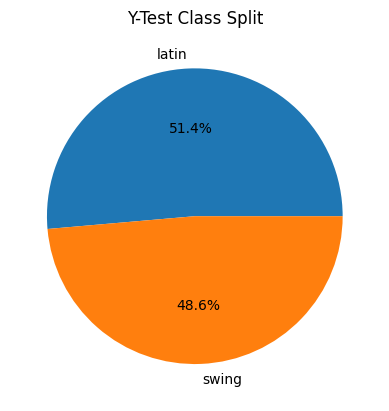

In [25]:
y_test_split = np.unique(y_test, return_counts=True)

plt.pie(y_test_split[1], labels = y_test_split[0], autopct='%1.1f%%')
plt.title('Y-Test Class Split')
plt.show()

## Baseline

In [26]:
total_frames = y_test_split[1] + y_train_split[1] + y_val_split[1]
swing_percent = round(total_frames[0]/total_frames.sum()*100, 2)
latin_percent = round(total_frames[1]/total_frames.sum()*100, 2)

print('swing has', total_frames[0], ' out of ', total_frames.sum(),'frames in the dataset. That is ', swing_percent, '% of the dataset.')
print('latin has', total_frames[1], ' out of ', total_frames.sum(),'frames in the dataset. That is ', latin_percent, '% of the dataset.')

swing has 5648  out of  10937 frames in the dataset. That is  51.64 % of the dataset.
latin has 5289  out of  10937 frames in the dataset. That is  48.36 % of the dataset.


When dealing with classification problems, a simple, but useful baseline is to select the majority class (the most common label in the training set) and use it as the prediction for all inputs. Our dataset consists of 5,648 swing examples (52%), and 5,289 latin examples (46%). So our majority class baseline classifies everything as swing. For our particular dataset, this will yield an accuracy of 52%. 

Baseline Class: Swing

Baseline Accuracy: 52%

## Model Prep and Setup

In [27]:
# then train and do the model

# prepping the model 
# Define the body part labels
body_part_labels = [
    "nose_x_p0", "nose_y_p0", 
    "left_eye_x_p0", "left_eye_y_p0", 
    "right_eye_x_p0", "right_eye_y_p0", 
    "left_ear_x_p0", "left_ear_y_p0", 
    "right_ear_x_p0", "right_ear_y_p0", 
    "left_shoulder_x_p0", "left_shoulder_y_p0", 
    "right_shoulder_x_p0", "right_shoulder_y_p0", 
    "left_elbow_x_p0", "left_elbow_y_p0", 
    "right_elbow_x_p0", "right_elbow_y_p0", 
    "left_wrist_x_p0", "left_wrist_y_p0", 
    "right_wrist_x_p0", "right_wrist_y_p0", 
    "left_hip_x_p0", "left_hip_y_p0", 
    "right_hip_x_p0", "right_hip_y_p0", 
    "left_knee_x_p0", "left_knee_y_p0", 
    "right_knee_x_p0", "right_knee_y_p0", 
    "left_ankle_x_p0", "left_ankle_y_p0", 
    "right_ankle_x_p0", "right_ankle_y_p0",
    "nose_x_p1", "nose_y_p1", 
    "left_eye_x_p1", "left_eye_y_p1", 
    "right_eye_x_p1", "right_eye_y_p1", 
    "left_ear_x_p1", "left_ear_y_p1", 
    "right_ear_x_p1", "right_ear_y_p1", 
    "left_shoulder_x_p1", "left_shoulder_y_p1", 
    "right_shoulder_x_p1", "right_shoulder_y_p1", 
    "left_elbow_x_p1", "left_elbow_y_p1", 
    "right_elbow_x_p1", "right_elbow_y_p1", 
    "left_wrist_x_p1", "left_wrist_y_p1", 
    "right_wrist_x_p1", "right_wrist_y_p1", 
    "left_hip_x_p1", "left_hip_y_p1", 
    "right_hip_x_p1", "right_hip_y_p1", 
    "left_knee_x_p1", "left_knee_y_p1", 
    "right_knee_x_p1", "right_knee_y_p1", 
    "left_ankle_x_p1", "left_ankle_y_p1", 
    "right_ankle_x_p1", "right_ankle_y_p1"
]

# Create a dictionary to map body part labels to column indices
body_part_mapping = {label: i for i, label in enumerate(body_part_labels)}

# Access the x-coordinate of the left eye for all frames
left_eye_x_coordinates = X_train_flattened[:, body_part_mapping["left_eye_x_p0"]]
print(left_eye_x_coordinates)
print(len(left_eye_x_coordinates))

# Access the y-coordinate of the right shoulder for all frames
right_shoulder_y_coordinates = X_train_flattened[:, body_part_mapping["right_shoulder_y_p0"]]
# print(right_shoulder_y_coordinates)
print(len(right_shoulder_y_coordinates))

# Access both x and y coordinates of the nose for all frames
nose_coordinates = X_train_flattened[:, [body_part_mapping["nose_x_p0"], body_part_mapping["nose_y_p0"]]]
# print(nose_coordinates)
print(len(nose_coordinates))


[[1219.24707031  351.27578735]
 [1039.72106934  349.84628296]
 [1134.28442383  373.45043945]
 ...
 [ 671.73815918   93.78833771]
 [ 668.14324951  113.04400635]
 [ 643.58740234  119.34065247]]
7337
7337
7337


In [28]:
X_train.reshape(X_train.shape[0], -1)

array([[1220.24462891,  359.27420044, 1218.24951172, ...,  647.20147705,
         950.31896973,  704.09783936],
       [1044.71728516,  358.83181763, 1048.71411133, ...,  745.07452393,
        1229.54602051,  729.09619141],
       [1136.27880859,  381.44818115, 1135.28161621, ...,  715.73901367,
         922.19732666,  712.74230957],
       ...,
       [ 601.8237915 ,  118.7824707 ,  606.81768799, ...,  317.84790039,
         531.73815918,  317.84790039],
       [ 675.11553955,  127.02546692,  677.10766602, ...,  264.82147217,
         636.50079346,  264.82147217],
       [ 645.58398438,  133.32931519,  650.57525635, ...,  536.69494629,
          52.92927551,  536.69494629]])

In [29]:
df_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1), columns=body_part_labels)
df_train['label'] = y_train
df_train

,nose_x_p0,nose_y_p0,left_eye_x_p0,left_eye_y_p0,right_eye_x_p0,right_eye_y_p0,left_ear_x_p0,left_ear_y_p0,right_ear_x_p0,right_ear_y_p0,...,right_hip_y_p1,left_knee_x_p1,left_knee_y_p1,right_knee_x_p1,right_knee_y_p1,left_ankle_x_p1,left_ankle_y_p1,right_ankle_x_p1,right_ankle_y_p1,label
0,1220.244629,359.274200,1218.249512,345.276978,1219.247070,351.275787,1237.203003,340.277954,1269.124634,334.279144,...,482.501526,980.218323,584.316040,930.386108,605.277832,1021.080750,647.201477,950.318970,704.097839,swing
1,1044.717285,358.831818,1048.714111,351.843079,1039.721069,349.846283,1049.713379,352.841461,1013.741272,344.854309,...,548.341064,1150.725342,643.212524,1197.618652,655.196289,1203.604980,745.074524,1229.546021,729.096191,swing
2,1136.278809,381.448181,1135.281616,369.451599,1134.284424,373.450439,1151.237427,364.453003,1183.149170,354.455841,...,516.958008,1062.681030,612.852356,947.105774,613.851257,1068.659058,715.739014,922.197327,712.742310,swing
3,1143.079102,376.120636,1141.080078,364.145142,1138.081543,366.141052,1154.073730,356.161469,1187.057617,343.188019,...,506.741180,1045.345581,598.648987,930.782959,612.635010,1062.280884,713.533813,915.840027,713.533813,swing
4,1142.615723,375.984772,1141.618042,363.991821,1138.625000,365.990631,1153.590088,355.996521,1186.513550,343.004150,...,507.162354,1046.579468,603.155151,930.682739,612.154480,1062.565186,713.146912,915.696106,714.146851,swing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7332,682.381958,121.517517,676.393005,106.541267,698.352600,89.568176,639.461060,118.522270,687.372803,119.520683,...,466.246338,585.734436,498.094482,548.100220,472.217865,572.859558,520.985352,547.109863,524.966370,latin
7333,662.148987,108.653435,662.148987,94.660049,638.210754,96.659103,668.133545,96.659103,665.141235,95.659576,...,311.524597,558.463074,316.521423,558.463074,316.521423,558.463074,316.521423,558.463074,316.521423,latin
7334,601.823792,118.782471,606.817688,103.785995,671.738159,93.788338,636.780945,96.787636,640.776062,94.788109,...,317.847900,531.738159,317.847900,531.738159,317.847900,531.738159,317.847900,531.738159,317.847900,latin
7335,675.115540,127.025467,677.107666,116.040039,668.143250,113.044006,566.546814,125.028114,637.265930,112.045334,...,264.821472,671.215576,264.821472,643.443726,264.821472,597.818542,264.821472,636.500793,264.821472,latin


In [30]:
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_val_flattened_reshaped = X_val_flattened.reshape(X_val_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)
print(X_train_flattened_reshaped.shape)
print(X_val_flattened_reshaped.shape)
print(X_test_flattened_reshaped.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(7337, 68)
(700, 68)
(2900, 68)
(7337,)
(700,)
(2900,)


In [31]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators= 10, random_state=42)
# train accuracy: 0.9986370451138067 val accuracy: 0.6685714285714286 test accuracy 0.5044827586206897

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# prediction on training data
y_pred_train = model.predict(X_train_flattened_reshaped)

# prediction on validation data
y_pred_val = model.predict(X_val_flattened_reshaped)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_test = accuracy_score(y_test, y_pred)
print('train accuracy:', accuracy_train, 'val accuracy:', accuracy_val, 'test accuracy', accuracy_test)

train accuracy: 0.9986370451138067 val accuracy: 0.6685714285714286 test accuracy 0.5044827586206897


In [32]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(model.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [33]:
# narrow down parameters using RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 9]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 10, 40]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'max_features': ['sqrt'], 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 100, None], 'min_samples_split': [2, 5, 9], 'min_samples_leaf': [3, 10, 40], 'bootstrap': [True, False]}


In [34]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_flattened_reshaped, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 100, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [3, 10, 40],
                                        'min_samples_split': [2, 5, 9],
                                        'n_estimators': [10, 120, 230, 340, 450,
                                                         560, 670, 780, 890,
                                                         1000]},
                   random_state=42, verbose=1)

In [35]:
rf_random.best_params_

{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 36,
 'bootstrap': True}

In [36]:
# checking model improvement 
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)

base_model.fit(X_train_flattened_reshaped, y_train)

base_accuracy = evaluate(base_model, X_test_flattened_reshaped, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_flattened_reshaped, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy)))

Model Performance
Test Set Accuracy = 0.50%.
Model Performance
Test Set Accuracy = 0.48%.
Improvement of -2.62%.


In [38]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 60, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [8, 10, 15],
    'min_samples_split': [3, 6, 9],
    'n_estimators': [100, 200, 300, 600]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1)

In [39]:
# Fit the grid search to the data
grid_search.fit(X_train_flattened_reshaped, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy_test = evaluate(best_grid, X_test_flattened_reshaped, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy_test - base_accuracy)))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Model Performance
Test Set Accuracy = 0.46%.
Improvement of -4.07%.


In [40]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=15, min_samples_split=3)

In [50]:
# Final Model Parameters according to the hyperparameter tuning

# best model (also the most basic model)
#model = RandomForestClassifier(n_estimators= 10, random_state=42)
# train accuracy: 0.9986370451138067 val accuracy: 0.6685714285714286 test accuracy 0.5044827586206897

model = RandomForestClassifier(max_depth = 20, random_state=42, min_samples_leaf=15, min_samples_split=3)
# train accuracy: 0.972877197764754 val accuracy: 0.7485714285714286 test accuracy 0.4589655172413793

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# prediction on training data
y_pred_train = model.predict(X_train_flattened_reshaped)

# prediction on validation data
y_pred_val = model.predict(X_val_flattened_reshaped)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_test = accuracy_score(y_test, y_pred)
print('train accuracy:', accuracy_train, 'val accuracy:', accuracy_val, 'test accuracy', accuracy_test)

train accuracy: 0.972877197764754 val accuracy: 0.7485714285714286 test accuracy 0.4589655172413793


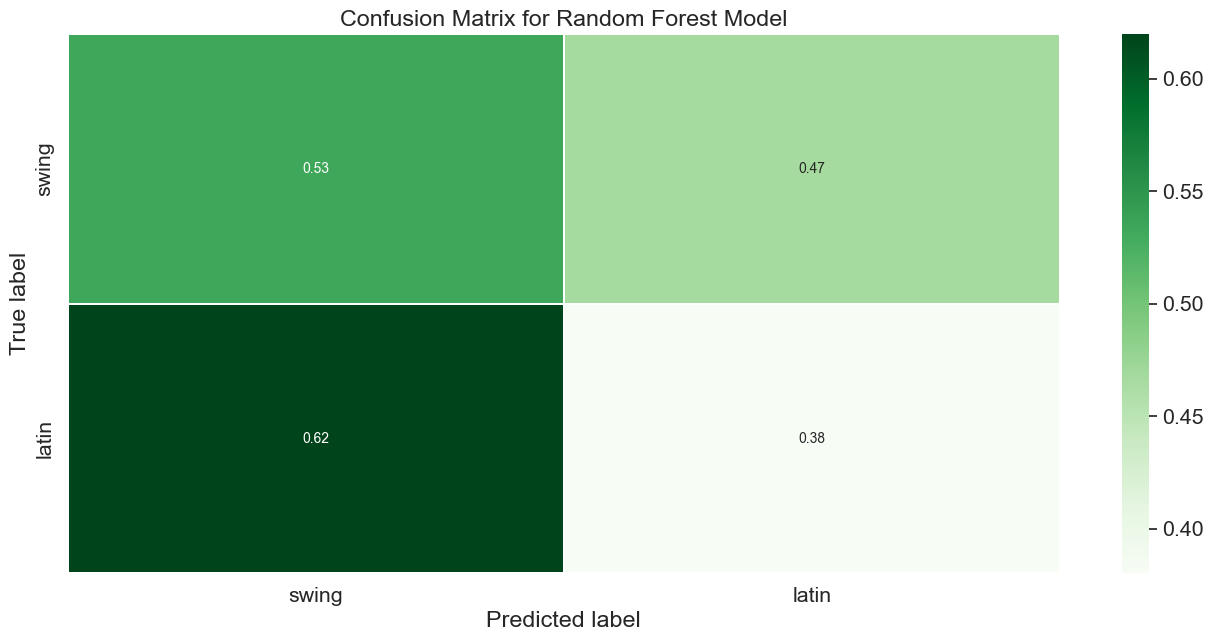

In [51]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['swing', 'latin']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks2, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [49]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       latin       0.51      0.63      0.57      1490
       swing       0.49      0.37      0.42      1410

    accuracy                           0.50      2900
   macro avg       0.50      0.50      0.49      2900
weighted avg       0.50      0.50      0.50      2900

